### ECE471, Selected Topics in Machine Learning – Assignment 2
Shailesh Patro

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.random import randn
from sklearn.utils import shuffle

In [13]:
iterations = 400
regularization_rate=0.003
N = 500
batch_size=20
learning_rate = 0.001
split_amount=N*2/batch_size
batch_index=np.arange(split_amount)
n_layer = [2, 20, 40, 20, 2]

# I tried  initially with one hidden layer and 10000 iterations with a high learning rate and relatively low regularization rate of 0.03. 
# Upon failing with a few different permutations of activation functions, regularization rates, learning rate, batch sizes and 
# layers, I decided to take a smarter route and attempt these permutation through an online tensorflow playground  (https://playground.tensorflow.org/)
# which allowed me to get a better grasp of what is the most optimal way to get high accuracy


In [3]:
def generate_training_data():
    # Came across a paper while working with a few other students that had code repository for spiral generation
    # The paper associated is called "Quantifying structural time varying changes in helical data" by Sameer Singh
    X = []
    Y = []
    for spiral in range(2):
        r=np.linspace(1, 5, N) 
        t=np.linspace(spiral*3, (spiral+3)*3, N)+ 0.3*randn(1,N);
        X.append([r*np.sin(t),r*np.cos(t)])
        Y.append((spiral)*np.ones((N,1)))
    X = np.squeeze(X)
    Y = np.squeeze(Y)
    x_sample = np.concatenate((X[0].T,X[1].T))
    y_sample = np.concatenate((Y[0].T,Y[1].T))
    x_sample,y_sample=shuffle(x_sample,y_sample,random_state=0)
    y_sample1=np.stack((y_sample,1-y_sample)).T
    x_batched = np.split(x_sample,split_amount)
    y_batched = np.split(y_sample1,split_amount)
    return x_batched, y_batched, x_sample, y_sample

x_samp, y_samp, x_sample, y_sample = generate_training_data()

In [4]:
tf_X = tf.placeholder(tf.float32, [batch_size, n_layer[0]])
tf_Y = tf.placeholder(tf.float32, [batch_size, n_layer[-1]])
weights = {
    'w1': tf.Variable(tf.random_normal([n_layer[0], n_layer[1]])),
    'w2': tf.Variable(tf.random_normal([n_layer[1], n_layer[2]])),
    'w3': tf.Variable(tf.random_normal([n_layer[2], n_layer[3]])),
    'out': tf.Variable(tf.random_normal([n_layer[3], n_layer[-1]]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_layer[1]])),
    'b2': tf.Variable(tf.random_normal([n_layer[2]])),
    'b3': tf.Variable(tf.random_normal([n_layer[3]])),
    'out': tf.Variable(tf.random_normal([n_layer[-1]]))
}

layer_1 = tf.nn.relu(tf.add(tf.matmul(tf_X, weights['w1']), biases['b1'])) 
layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])) 
layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])) 
logits = tf.nn.softmax(tf.matmul(layer_3, weights['out']) + biases['out']) 

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=tf_Y))
trainable_vars=tf.trainable_variables()
loss_op += tf.add_n([tf.nn.l2_loss(var) for var in trainable_vars]) * regularization_rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
init = tf.global_variables_initializer()

In [5]:
sess=tf.Session() 
sess.run(init)
losses=[]
for iteration in range(iterations):
    np.random.shuffle(batch_index)
    avgCost = 0
    for i in batch_index.astype(int):
        _,loss_1=sess.run([train_op,loss_op],feed_dict = {tf_X:x_samp[i],tf_Y:y_samp[i]})
        avgCost+=loss_1
    if iteration % 20 == 0:
            print("Iteration number: {:4d}, Loss: {:.9f}".format(iteration, avgCost/len(batch_index)))

Iteration number:    0, Loss: 3.360028586
Iteration number:   20, Loss: 1.662877502
Iteration number:   40, Loss: 1.229886103
Iteration number:   60, Loss: 0.973196265
Iteration number:   80, Loss: 0.818396969
Iteration number:  100, Loss: 0.737393856
Iteration number:  120, Loss: 0.668206403
Iteration number:  140, Loss: 0.524268172
Iteration number:  160, Loss: 0.492908396
Iteration number:  180, Loss: 0.475566167
Iteration number:  200, Loss: 0.460528201
Iteration number:  220, Loss: 0.449220809
Iteration number:  240, Loss: 0.439072605
Iteration number:  260, Loss: 0.430410239
Iteration number:  280, Loss: 0.424153290
Iteration number:  300, Loss: 0.419264686
Iteration number:  320, Loss: 0.414623338
Iteration number:  340, Loss: 0.411489045
Iteration number:  360, Loss: 0.409518484
Iteration number:  380, Loss: 0.407381171


In [6]:
yhat=[]
for i in x_samp:
    yhat.append(sess.run(logits,feed_dict = {tf_X:i}))
yhat=np.array(yhat)
yhat=np.concatenate(yhat)
predict_prob=np.squeeze(yhat>0.5)
accuracy = np.sum(np.equal(predict_prob[:,0], y_sample==1)) * 100 / 1000
domain = np.arange(-6, 6, 0.1)
xCont, yCont = np.meshgrid(domain, domain)
xflat=xCont.flatten()
yflat=yCont.flatten()
together=np.stack((xflat,yflat),axis=1)
together_batches=np.split(together,len(together)/batch_size)

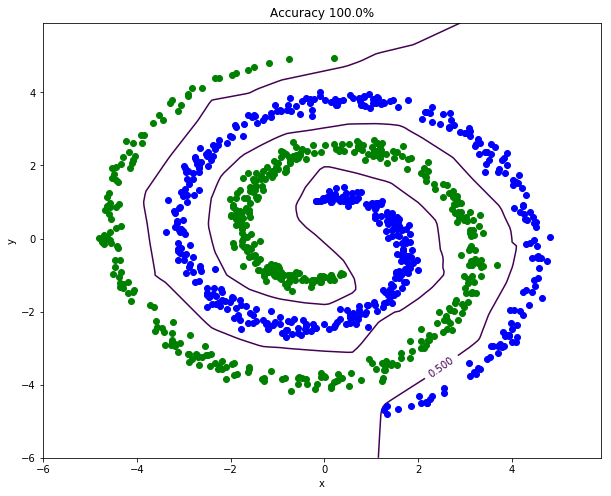

In [7]:
z =[]
for i in together_batches:
    z.append(sess.run(logits, feed_dict={tf_X: i})[:,1])
z=np.array(z)
z=np.concatenate(z)
z=np.reshape(z,(120,120))
plot_x=x_sample[:,0]
plot_y=x_sample[:,1]

plt.figure(figsize=[10,8])
bound = plt.contour(xCont, yCont, z, levels=[0.5])
plt.clabel(bound, inline=1, fontsize=10)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Accuracy {}%'.format(accuracy))
plt.plot(plot_x[predict_prob[:,0] == True], plot_y[predict_prob[:,0] == True], 'go', label='Class 1')
plt.plot(plot_x[predict_prob[:,0] == False], plot_y[predict_prob[:,0] == False], 'bo', label='Class 2')
plt.show()